In [1]:
import torch
def bidiagonal_inverse_batched(a, b):
    # a is of shape batch x n, b is of shape batch x (n-1)
    batch, n = a.size()
    # b = torch.cat([torch.ones(batch, 1), b_], dim=1)    
    theta = torch.zeros(batch, n+1)
    phi = torch.zeros(batch, n+1)    
    # compute a inverse
    a_inv = 1/a
    # embed a_inv into diagonal
    # inv = torch.diag_embed(a_inv)
    inv = torch.zeros(batch, n, n)
    for i in range(n):
        inv[:, i, i] = a_inv[:, i]
    # init
    theta[:, 0] = 1
    theta[:, 1] = a[:, 0]
    # phi[:, n] = 1
    # phi[:, n-1] = a[:, n-1]
    for i in range(2, n+1):
        theta[:, i] = a[:, i-1] * theta[:, i-1]
    # for i in range(n-1, 0, -1):
    #     phi[:, i] = a[:, i-1] * phi[:, i+1]
    # loop over i and j
    for j in range(1, n+1):
        for i in range(j-1, 0, -1):
            # i, j are 1-indexed
            inv[:, i-1, j-1] = -b[:, i-1] * inv[:, i, j-1] * theta[:, i-1] / theta[:, i]
    return inv
            

# unit test
if __name__ == '__main__':
    import torch
    diag = torch.randn(2, 3)
    off_diag = torch.randn(2, 2)
    # embed into a full matrix
    mat = torch.diag_embed(diag) + torch.diag_embed(off_diag, offset=1)
    # print(mat)
    # print(bidiagonal_inverse_batched(diag, off_diag), torch.inverse(mat))
    print(torch.norm(bidiagonal_inverse_batched(diag, off_diag) -torch.inverse(mat)))
    # print(torch.isclose(bidiagonal_inverse_batched(diag, off_diag), torch.inverse(mat)))
    


tensor(7.0162e-07)


In [37]:
loss_fn = torch.nn.BCELoss(reduction='mean')
a = torch.nn.Sigmoid()(torch.randn(100,))
b = torch.randint(0, 2, (100,)).float()
# print(a, b)
loss = loss_fn(a, b)
import math
print(loss, math.log(2))

tensor(0.8214) 0.6931471805599453


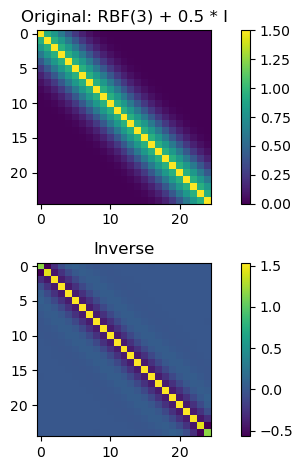

In [1]:
import torch
import matplotlib.pyplot as plt

def rbf_kernel(time, sigma):
    # sigma is a scalar, time is number of bins
    # return kernel of shape (time, time)
    time_range = torch.arange(time).unsqueeze(0).float()
    time_diff = time_range - time_range.t()
    kernel = torch.exp(-time_diff**2 / (2 * sigma**2))    
    return kernel

def kl_divergence_normal(q_mean, q_cov):        
    log_det = torch.logdet(cov)
    trace_term = torch.einsum("...ii", cov)
                
    return 0.5 * torch.sum(torch.sum(q_mean.pow(2), dim=1) + trace_term - q_mean.shape[1] - log_det)
    
def kl_divergence_any(q_mean, q_cov, p_mean, p_cov, p_inv, p_log_det):
    # insert batch dimension for p_cov if not present        
    if len(p_inv.shape) == 2:
        # repeat p
        p_cov = p_cov.unsqueeze(0).repeat(q_mean.shape[0], 1, 1)
        p_inv = p_inv.unsqueeze(0).repeat(q_mean.shape[0], 1, 1)
        p_log_det = p_log_det.unsqueeze(0).repeat(q_mean.shape[0])     
    q_log_det = torch.logdet(q_cov)
    log_det_term = p_log_det - q_log_det        
    # trace_term = torch.einsum("...ii", torch.bmm(p_inv, q_cov))
    # print(p_cov.shape, q_cov.shape)
    trace_term = torch.einsum("...ii", torch.linalg.solve(p_cov, q_cov))        
            
    diff_term = (q_mean - p_mean).unsqueeze(-1)
    # print(diff_term.shape)
    # mu_term = torch.sum(torch.bmm(diff_term.transpose(1, 2), torch.bmm(p_inv, diff_term)))        
    mu_term = torch.sum(diff_term * torch.linalg.solve(p_cov, diff_term))        
    
    return 0.5 * torch.sum(log_det_term - q_mean.shape[1] + trace_term + mu_term)

# A = torch.randn(1, 25, 25)
# cov = torch.bmm(A, A.transpose(1, 2))
# mean = torch.randn(1, 25)
# print(kl_divergence_normal(mean, cov))
# kernel = 0.9*rbf_kernel(25, 0.001) + 0.1 * torch.eye(25)
# print(kl_divergence_any(mean, cov, 0, kernel, torch.inverse(kernel), torch.logdet(kernel)))
a = rbf_kernel(25, 3) + 0.5 * torch.eye(25) 
inverse = torch.inverse(a)
plt.subplot(2, 1, 1)
plt.imshow(a)
plt.title("Original: RBF(3) + 0.5 * I")
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(inverse)
plt.title("Inverse")
plt.tight_layout()
plt.colorbar()


In [ ]:
import sklearn.gaussian_process as gp
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# read pkl data of z files
# with open('z_data.pkl', 'rb') as f:
with open('z_presoftmax.pkl', 'rb') as f:
    z_tr, z_te = pickle.load(f)
a = np.concatenate([z_tr, z_te], axis=0)

In [ ]:
# plot trial-averaged z
plt.figure()
plt.plot(np.mean(a, axis=0))
plt.title('Trial-averaged z pre-softmax')
plt.show()

In [ ]:
z = a[:, :, 1:2]
# time_test = np.array([4, 9, 14, 19, 24])
# time_train = np.array([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23])
time_test = np.sort(np.random.choice(25, 5, replace=False))
time_train = np.sort(np.setdiff1d(np.arange(25), time_test))
# print(time_test)
time_all = np.arange(25)
alpha_l = [1e-3, 1e-2, 1e-1, 0.5, 1.0, 1.5, 10]
length_l = [0.01, 0.1, 1, 2, 5, 10, 20, 40]

In [ ]:
# set up the GP model
results = {}
for alpha in alpha_l:
    for l_scale in length_l:
        rbf_kernel = gp.kernels.RBF(l_scale, length_scale_bounds='fixed')
        res = []
        for sample in range(len(z)):
            x_train, x_test = z[sample][time_train], z[sample][time_test]
            gp_model = gp.GaussianProcessRegressor(kernel=rbf_kernel, alpha=alpha).fit(time_train[:, np.newaxis], x_train)
            model_score = gp_model.score(time_test[:, np.newaxis], x_test)        
            res.append(model_score)
        results[(alpha, l_scale)] = np.mean(res)

In [ ]:
# plot on a 2d grid
fig, ax = plt.subplots()
cax = ax.matshow(np.array([[results[(alpha, l_scale)] for l_scale in length_l] for alpha in alpha_l]), cmap='hot')
# annotate with values
for i in range(len(alpha_l)):
    for j in range(len(length_l)):        
        # highlight the best value
        if results[(alpha_l[i], length_l[j])] == np.max([results[(alpha, l_scale)] for alpha in alpha_l for l_scale in length_l]):
            ax.text(j, i, round(results[(alpha_l[i], length_l[j])], 2), ha='center', va='center', color='blue')
        else:
            ax.text(j, i, round(results[(alpha_l[i], length_l[j])], 2), ha='center', va='center', color='green')
fig.colorbar(cax)
plt.xticks(np.arange(len(length_l)), length_l)
plt.yticks(np.arange(len(alpha_l)), alpha_l)
plt.xlabel('length scale')
plt.ylabel('alpha')
plt.title('R^2 score averaged across trials')
plt.show()

In [ ]:
# plot 4 random trials
length_scale, alpha = 2, 0.1
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
# z_idxs = np.random.randint(len(z), size=9)
z_idxs = np.arange(9)
rbf_kernel = gp.kernels.RBF(length_scale, length_scale_bounds='fixed')
for i, z_idx in enumerate(z_idxs):        
    gp_model = gp.GaussianProcessRegressor(kernel=rbf_kernel, alpha=alpha, normalize_y=True)    
    gp_model.fit(time_train[:, np.newaxis], z[z_idx][time_train])
    # model_score = gp_model.score(time, Y)
    # print(f'alpha=0.1, model_score={model_score}')
    # plot std
    predictions, std = gp_model.predict(time_all[:, np.newaxis], return_std=True)
    plt.subplot(3, 3, i + 1)
    plt.plot(time_all, predictions, marker='o', label='prediction')
    plt.fill_between(time_all, predictions - std, predictions + std, alpha=0.2)
    plt.plot(z[z_idx], marker='x', label='true')
plt.legend()

In [ ]:
X = np.random.uniform(-10.,10.,(100,1))
y = np.sin(X) + np.random.randn(100,1)*0.05
rbf_kernel = gp.kernels.RBF(0.1, length_scale_bounds=(1e-2, 1e2))
gp_model = gp.GaussianProcessRegressor(kernel=rbf_kernel, optimizer='fmin_l_bfgs_b', alpha=0.1).fit(X, y)
print(gp_model.kernel_)

In [ ]:
predictions, std = gp_model.predict(X, return_std=True)
plt.scatter(X, predictions, marker='o', label='prediction')
plt.scatter(X, y, marker='x', label='true')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
off_diag_elems = torch.ones(3)
diag_elems = torch.ones(4)

In [ ]:
# fill elements
prec = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
# cov = torch.inverse(prec)
# plt.imshow()
print(prec, prec @ prec.transpose(-1, -2))

In [ ]:
batch, time = diag_elems.shape
device = diag_elems.device
prec2 = torch.zeros(batch, time, time, device=device)
a_2 = diag_elems**2
b_2 = torch.cat([torch.zeros(batch, 1, device=device), off_diag_elems**2], dim=1)
ab = diag_elems[:, :-1] * off_diag_elems            
prec2 += torch.diag_embed(a_2+b_2, dim1=-2, dim2=-1)
off_diagonal = torch.diag_embed(ab, offset=1, dim1=-2, dim2=-1)            
prec2 += off_diagonal + off_diagonal.transpose(-2, -1)

In [ ]:
# check diff between prec1 and prec2
print(torch.norm(prec1 - prec2))

In [ ]:
l = 100
d = 5
mu1 = torch.zeros(l, d)
sigma1 = torch.eye(d, d).repeat(l, 1, 1)
mu = torch.randn(l, d)
A = torch.tril(torch.randn(l, d, d))
# make diagonal positive
diag = torch.diagonal(A, dim1=-2, dim2=-1)        
diag = nn.Softplus()(diag)
# set diag of A to diag
A = A - torch.diag_embed(torch.diagonal(A, dim1=-2, dim2=-1)) + torch.diag_embed(diag)

In [ ]:
p = torch.distributions.MultivariateNormal(mu1, scale_tril=sigma1)
q = torch.distributions.MultivariateNormal(mu, scale_tril=A)
# compute the kl divergence
kl_loss = torch.distributions.kl_divergence(q, p).sum()
print(kl_loss)

In [ ]:
cov = torch.bmm(A, torch.transpose(A, 1, 2))
det = torch.det(cov)
kl_loss = 0.5 * torch.sum(torch.sum(mu.pow(2), dim=1) + torch.einsum("...ii", cov) - mu.shape[1] - torch.log(det))
print(kl_loss, 'original')

In [ ]:
batch, dim, time = 10, 5, 100
bd = torch.randn(batch, time, 2*dim)
prec = torch.zeros(batch, dim, time, time)
for i in range(dim):
    diag_elems = bd[:, :, i]
    off_diag_elems = bd[:, :-1, i+dim]
    # fill elements
    prec[:, i, :, :] = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
    prec[:, i, :, :] = torch.bmm(prec[:, i, :, :].transpose(1, 2), prec[:, i, :, :])
    print(prec[0, i, :, :])

In [ ]:
from vae_unimodal import TimeSeries

In [ ]:
a = TimeSeries(10, 8, 2, 25, False, 1, False, 0.1)

In [ ]:
y = torch.randn(5, 25, 10)

In [ ]:
out = a.forward(y)
out[0].sample_n(10).shape

In [ ]:
# create matrix with 1 on diagonala and off diagonal
a = torch.eye(5, 5)
# put 1 on off diagonal
a += torch.diag_embed(torch.ones(4), 1)
# print(a.T @ a)
print(torch.linalg.inv(a.T @ a))

In [ ]:
from vae_gp import rbf_kernel
import matplotlib.pyplot as plt
import torch
a = rbf_kernel(25, 2) + 1e-2 * torch.eye(25)
b = torch.linalg.inv(a)
plt.imshow(b)
plt.colorbar()
# print(b)


In [ ]:
from vae_gp_combined import CustomDistribution
import torch.distributions as dist
import torch

In [ ]:
m, a = torch.randn(5, 10), torch.randn(5, 10, 10)
a = CustomDistribution(m, a)
print(a.kl_divergence_normal())

In [ ]:
d = dist.MultivariateNormal(m, covariance_matrix=a.get_covariance_matrix())

In [ ]:
print(dist.kl_divergence(d, dist.MultivariateNormal(torch.zeros(5, 10), torch.eye(10))).sum())

In [ ]:
from vae_gp import derivative_time_series
import torch
import matplotlib.pyplot as plt
# sine wave of 10 points
x = torch.linspace(0, 1, 10)
y = torch.sin(3.14 * x).unsqueeze(0).unsqueeze(-1)

In [ ]:
dx = derivative_time_series(y)
plt.plot(y[0, :, 0].numpy())
plt.plot(dx[0, :, 0].numpy())
plt.show()

In [ ]:

batch_size, z_size, time_length = 1, 2, 10
mapped = torch.randn(batch_size, time_length, 3*z_size)
# Obtain mean and precision matrix components
num_dim = len(mapped.shape)
perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
mapped_transposed = mapped.permute(perm)
mapped_mean = mapped_transposed[:, :z_size]
mapped_covar = mapped_transposed[:, z_size:]

mapped_covar = torch.nn.functional.softplus(mapped_covar)

mapped_reshaped = mapped_covar.reshape(batch_size, z_size, 2 * time_length)

dense_shape = [batch_size, z_size, time_length, time_length]
idxs_1 = torch.repeat_interleave(torch.arange(batch_size), z_size * (2 * time_length - 1))
idxs_2 = torch.tile(torch.repeat_interleave(torch.arange(z_size), (2 * time_length - 1)), dims=(batch_size,))
idxs_3 = torch.tile(torch.cat([torch.arange(time_length), torch.arange(time_length - 1)]), dims=(batch_size * z_size,))
idxs_4 = torch.tile(torch.cat([torch.arange(time_length), torch.arange(1, time_length)]), dims=(batch_size * z_size,))
idxs_all = torch.stack([idxs_1, idxs_2, idxs_3, idxs_4], dim=1)

# Obtain covariance matrix from precision one
mapped_values = mapped_reshaped[:, :, :-1].reshape(-1)
prec_sparse = torch.sparse_coo_tensor(idxs_all.T, mapped_values, dense_shape)
prec_tril = prec_sparse.to_dense() + torch.eye(prec_sparse.size(-1), device=prec_sparse.device)
cov_tril = torch.linalg.solve(prec_tril, torch.eye(prec_tril.size(-1), device=prec_tril.device))
cov_tril = torch.where(torch.isfinite(cov_tril), cov_tril, torch.zeros_like(cov_tril))

In [ ]:
# prec_sparse.to_dense()
torch.norm(prec_tril @ cov_tril - torch.eye(prec_tril.size(-1)))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cov_tril[0, 0])
plt.show()